# R4 on DECOY_MNIST

In [71]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FCNAugmented
from models.robust_regularizer import input_gradient_interval_regularizer, input_gradient_pgd_regularizer
from datasets import decoy_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-train the model

In [53]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:1


In [54]:
batch_size = 1000
dl_train, dl_test = decoy_mnist.get_dataloaders(train_batchsize=batch_size, test_batchsize=batch_size)

/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs = torch.tensor(train_imgs.clone().detach(), dtype=torch.float32) / 255
/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs = torch.tensor(test_imgs.clone().detach(), dtype=torch.float32) / 255
/homes/mg2720/phd/R4/examples/datasets/decoy_mnist.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels.clone().detach(), dtype=torch

In [55]:
dl_masks_train, dl_masks_test = decoy_mnist.get_masked_dataloaders(dl_train, dl_test)

torch.Size([60000]) torch.Size([60000, 28, 28])
{0: tensor(0.3333), 1: tensor(0.2980), 2: tensor(0.2667), 3: tensor(0.2353), 4: tensor(0.2000), 5: tensor(0.1686), 6: tensor(0.1373), 7: tensor(0.1020), 8: tensor(0.0706), 9: tensor(0.0392)}


In [56]:
def train_model_with(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k, k_schedule=None):
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	# pre-train the model
	progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
	for epoch in progress_bar:
		for i, (x, u, m) in enumerate(dl_masks_train):
			# Forward pass
			u, x, m = u.to(device), x.to(device).flatten(start_dim=1), m.to(device).flatten(start_dim=1)

			# For std, we will waste some time doing the bounds, but at least it is consistent across methods
			inp_grad_reg = input_gradient_interval_regularizer(
				model, x, u, "cross_entropy", epsilon, 0.0, regularizer_type=mlx_method, batch_masks=m, device=device
			)
			if mlx_method == "std":
				u = torch.nn.functional.one_hot(u, num_classes=10).squeeze().float()
				assert inp_grad_reg == 0
			output = model(x)
			std_loss = criterion(output, u)
			if k_schedule is not None:
				k = k_schedule(epoch, n_epochs, std_loss, inp_grad_reg)
			loss = std_loss + k * inp_grad_reg
			# Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			if i % 100 == 0:
				progress_bar.set_postfix({"std loss": std_loss.item(), "input grad loss": k * inp_grad_reg})

In [57]:
def test_model_acc(model):
    # evaluate the pre-trained model
    # here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
    param_n, param_l, param_u = ct_utils.get_parameters(model)
    all_acc, i = 0, 0
    for test_batch, test_labels in dl_test:
        all_acc += agt.test_metrics.test_accuracy(param_n, param_l, param_u, test_batch, test_labels, model=model)[1]
        i += 1
    all_acc /= i
    print("--- Pre-trained model accuracy ---")
    print(f"Nominal = {all_acc:.2g}")

In [58]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx):
    batch_input, batch_labels, batch_mask = batch_input.to(device), batch_labels.to(device), batch_mask.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [59]:
# define model, dataset and optimizer
num_epochs = 10
lr = 0.01
restarts = 1
epsilon = 0.1
# k is a coefficient for the regularization term
k = 0.2
ARCH = (784, 10, 512, 1)
model = FCNAugmented(*ARCH)
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
print(model)

FCNAugmented(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=10, bias=True)
  (4): Softmax(dim=-1)
)


Batch input shape: torch.Size([1000, 28, 28]), batch mask shape: torch.Size([1000, 28, 28])


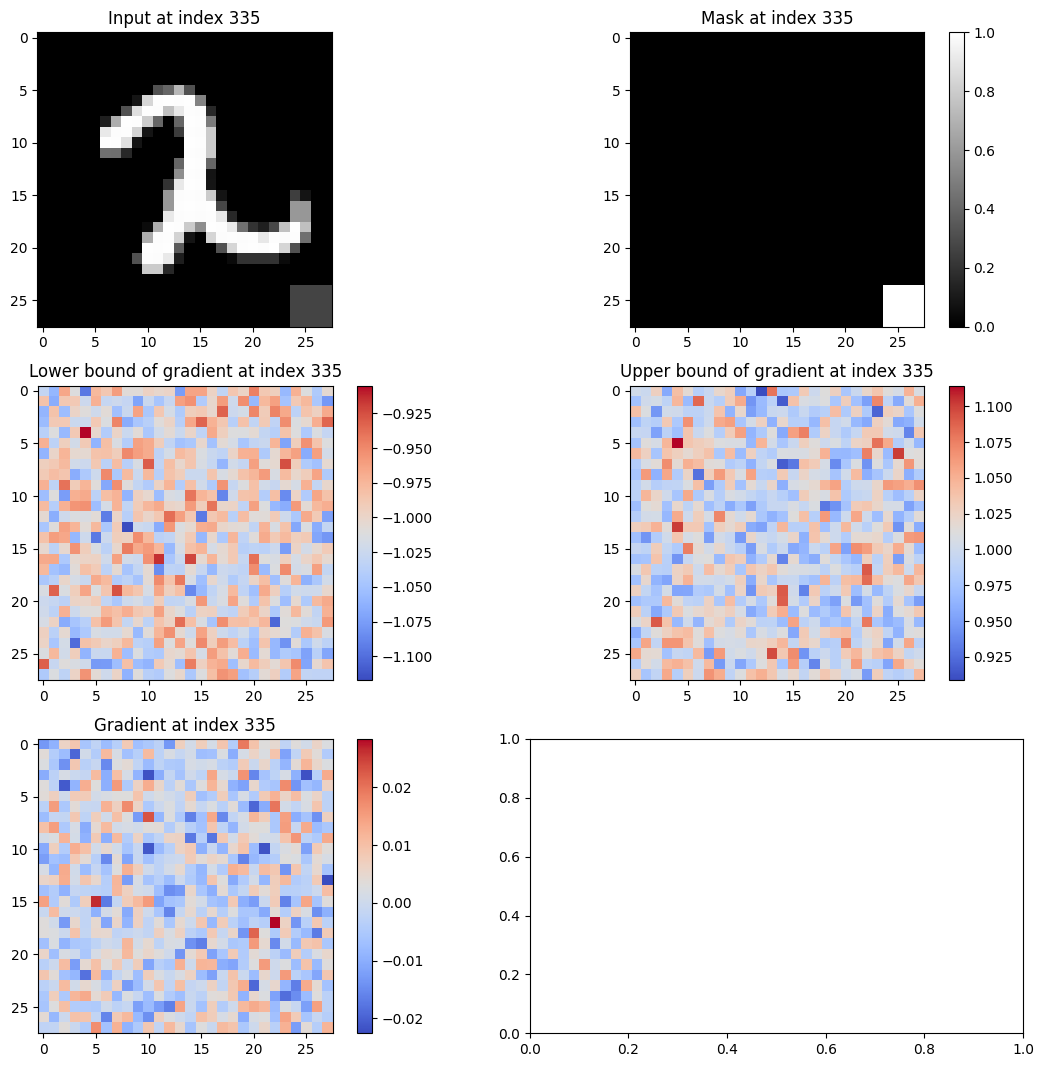

In [60]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
init_batch_train_with_masks = next(iter(dl_masks_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

## Experiments 

In [61]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.01

In [62]:
def test_delta_input_robustness(model):
    # The model needs to be delta input robust only in the irrelevant features
    num_robust = 0
    for test_batch, test_labels, test_masks in dl_masks_test:
        test_batch, test_labels, test_masks = test_batch.to(device), test_labels.to(device), test_masks.to(device)
        test_batch = test_batch.flatten(start_dim=1)
        test_masks = test_masks.flatten(start_dim=1)
        # The MLX method does not really matter, as we return the grads
        grad_bounds = input_gradient_interval_regularizer(model, test_batch, test_labels, "cross_entropy", epsilon, 0.0, return_grads=True, batch_masks=test_masks)
        d_l, d_u = grad_bounds[1]
        d_l, d_u = d_l.flatten(start_dim=1), d_u.flatten(start_dim=1)
        d_l, d_u = d_l * test_masks, d_u * test_masks
        # keep the dimensions, but remove the elements which are 0
        abs_diff = torch.abs(d_l - d_u)
        # [batch_size, input_dim]
        robust_grad_inputs = torch.where(abs_diff <= DELTA_INPUT_ROBUSTNESS_PARAM, True, False) # 1000 x 784
        # [batch_size]
        is_robust_grad = robust_grad_inputs.all(dim=0)
        num_robust += is_robust_grad.sum().item()
    num_robust /= len(dl_masks_test.dataset)
    print("--- Pre-trained model delta input robustness ---")
    print(f"Delta Input Robustness = {num_robust:.2g}")


### Standard Training

========== Training model with method std restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s, std loss=2.3, input grad loss=0]

Epoch: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it, std loss=1.47, input grad loss=0]


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.72


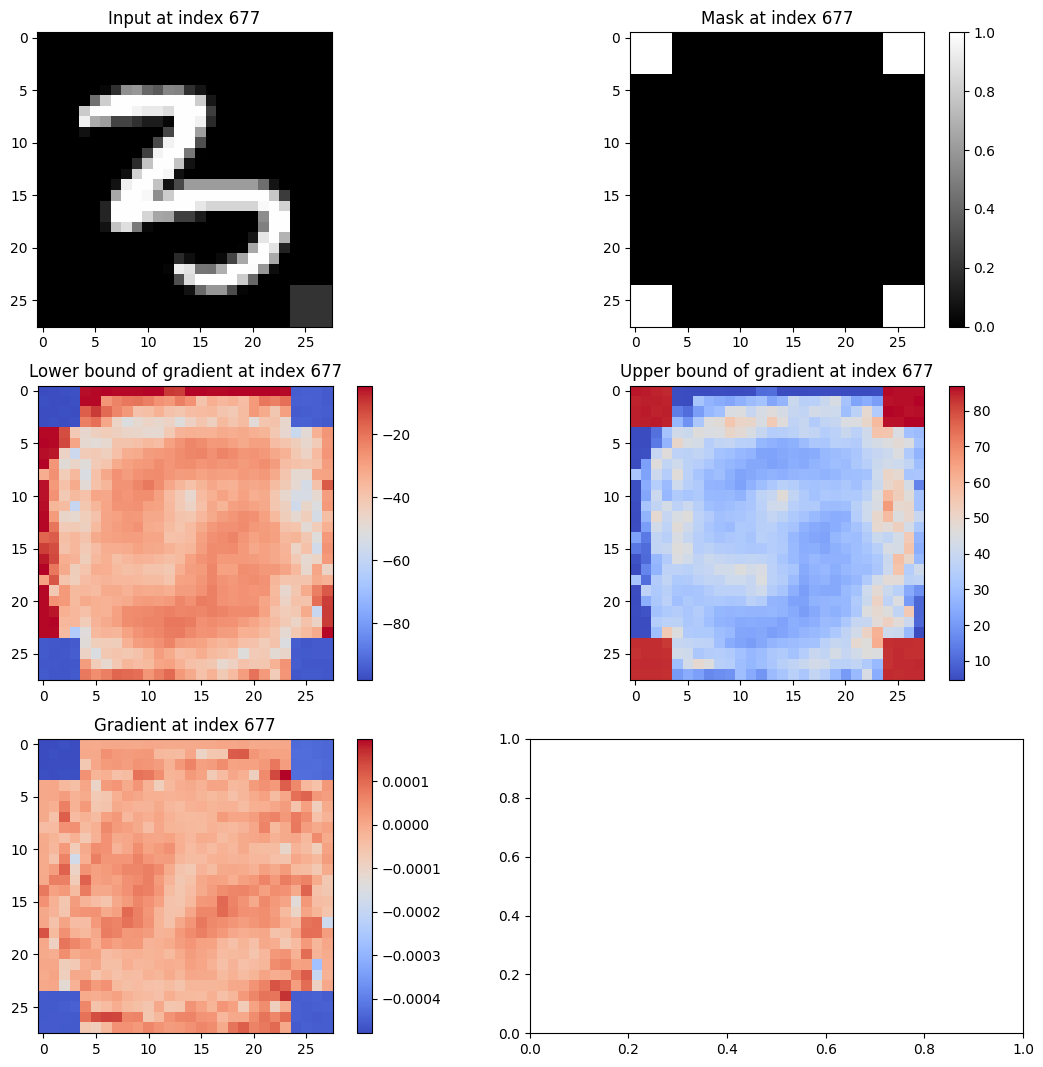

In [63]:
mlx_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    test_with_masks_batch = next(iter(dl_masks_test))
    test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    if i == restarts - 1:
        visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:14<00:00,  1.44s/it, std loss=2.05, input grad loss=tensor(36.1538, device='cuda:1', grad_fn=<MulBackward0>)]


--- Pre-trained model accuracy ---
Nominal = 0.4
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.72


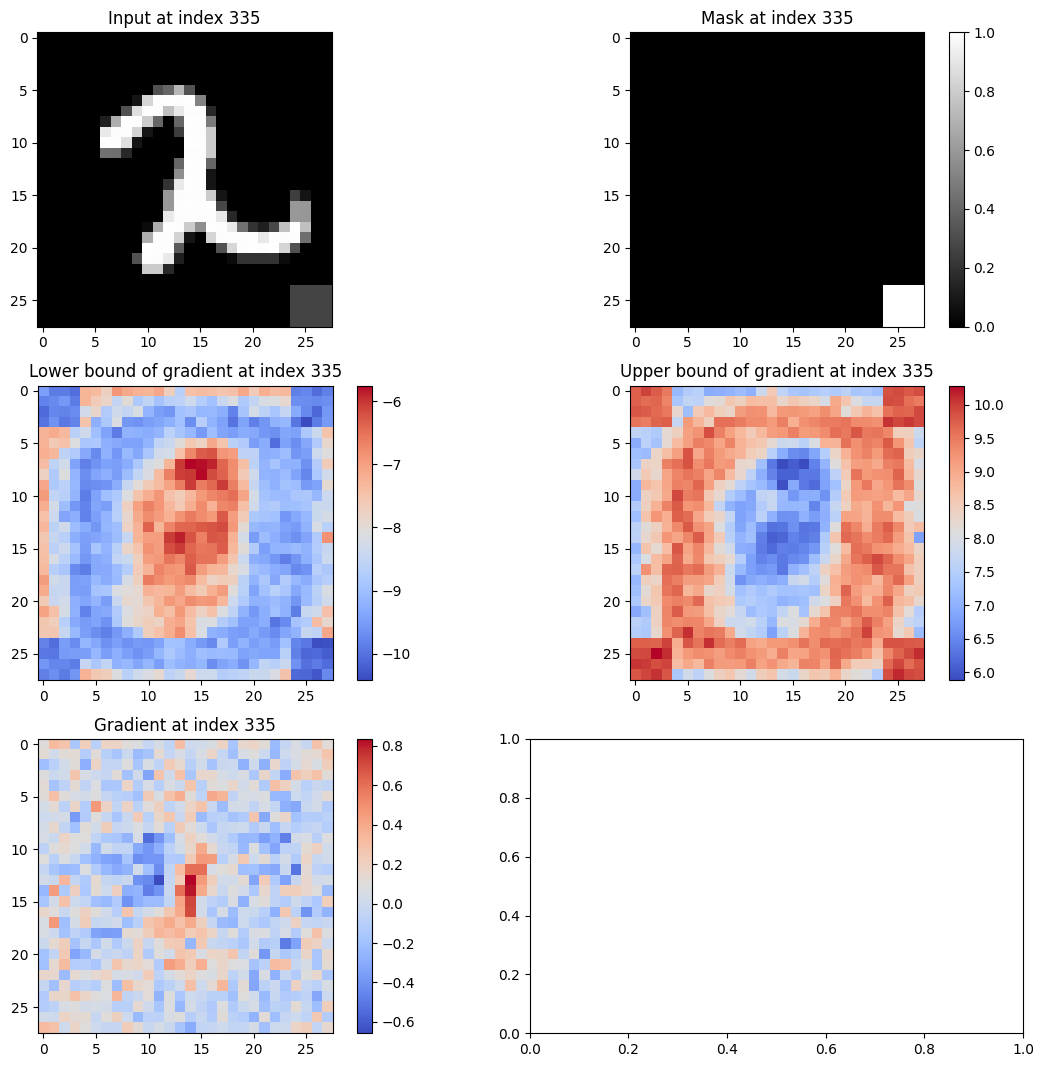

In [64]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
def rrr_k_schedule(curr_epoch, max_epochs, std_loss, rrr_loss):
    if curr_epoch <= max_epochs // 5:
        return 0.0
    else:
        # get magnitude difference in terms of order of magnitude
        loss_diff = rrr_loss - std_loss
        if loss_diff < 0:
            return 1.0
        orders_of_mag = torch.floor(torch.log10(loss_diff))
        # the 2 is there to allow for a bit of a margin
        return 1 / (2 * (10 ** (orders_of_mag - 1)))


for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, k, k_schedule=rrr_k_schedule)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

========== Training model with method R4, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s, std loss=2.3, input grad loss=tensor(0.0082, device='cuda:1', grad_fn=<MulBackward0>)]

Epoch: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it, std loss=1.48, input grad loss=tensor(0.0029, device='cuda:1', grad_fn=<MulBackward0>)]


--- Pre-trained model accuracy ---
Nominal = 0.98
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.72


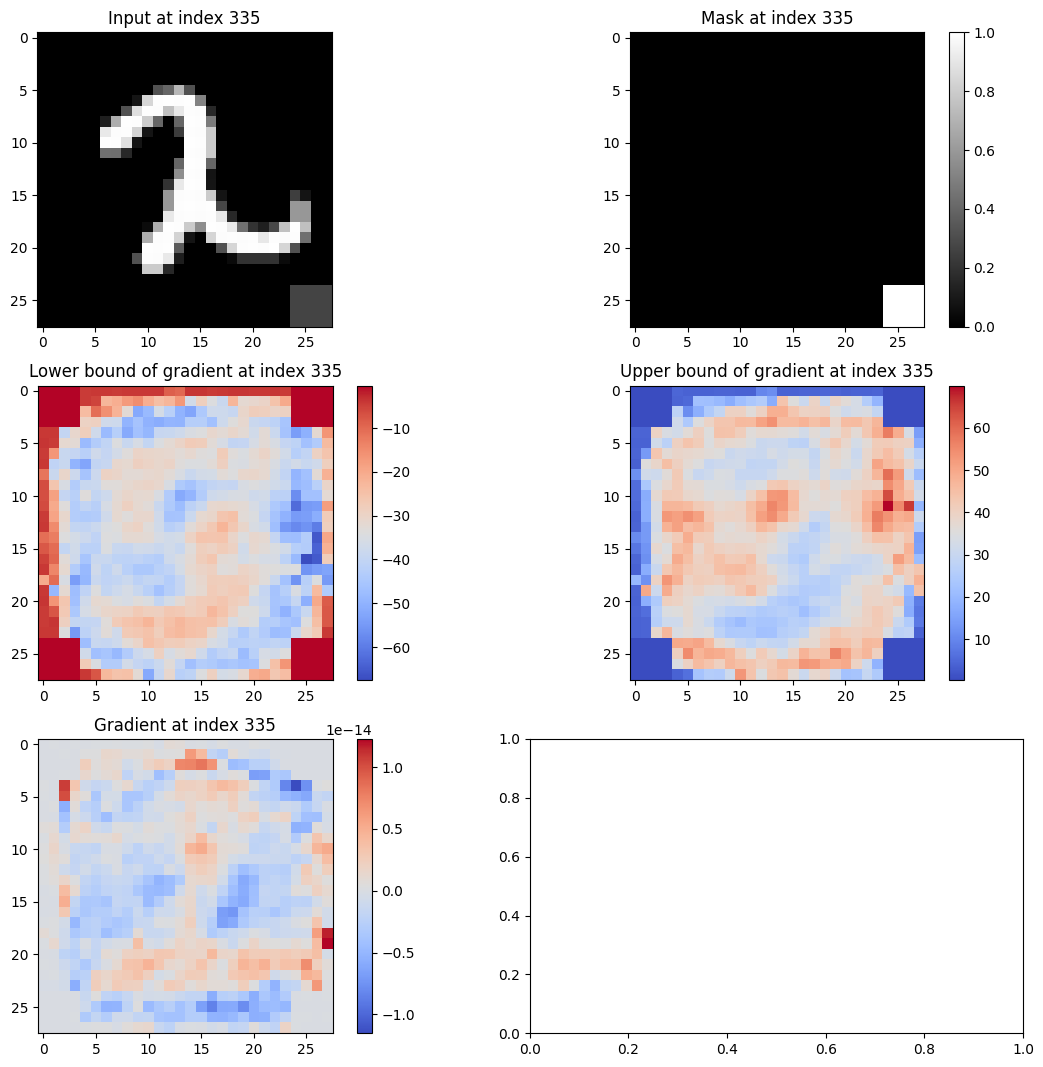

In [65]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, epsilon, idx_to_visualize)

IBP-EX Training

========== Training model with method ibp_ex restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it, std loss=1.6, input grad loss=tensor(0.5812, device='cuda:1', grad_fn=<MulBackward0>)]


--- Pre-trained model accuracy ---
Nominal = 0.91
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.72


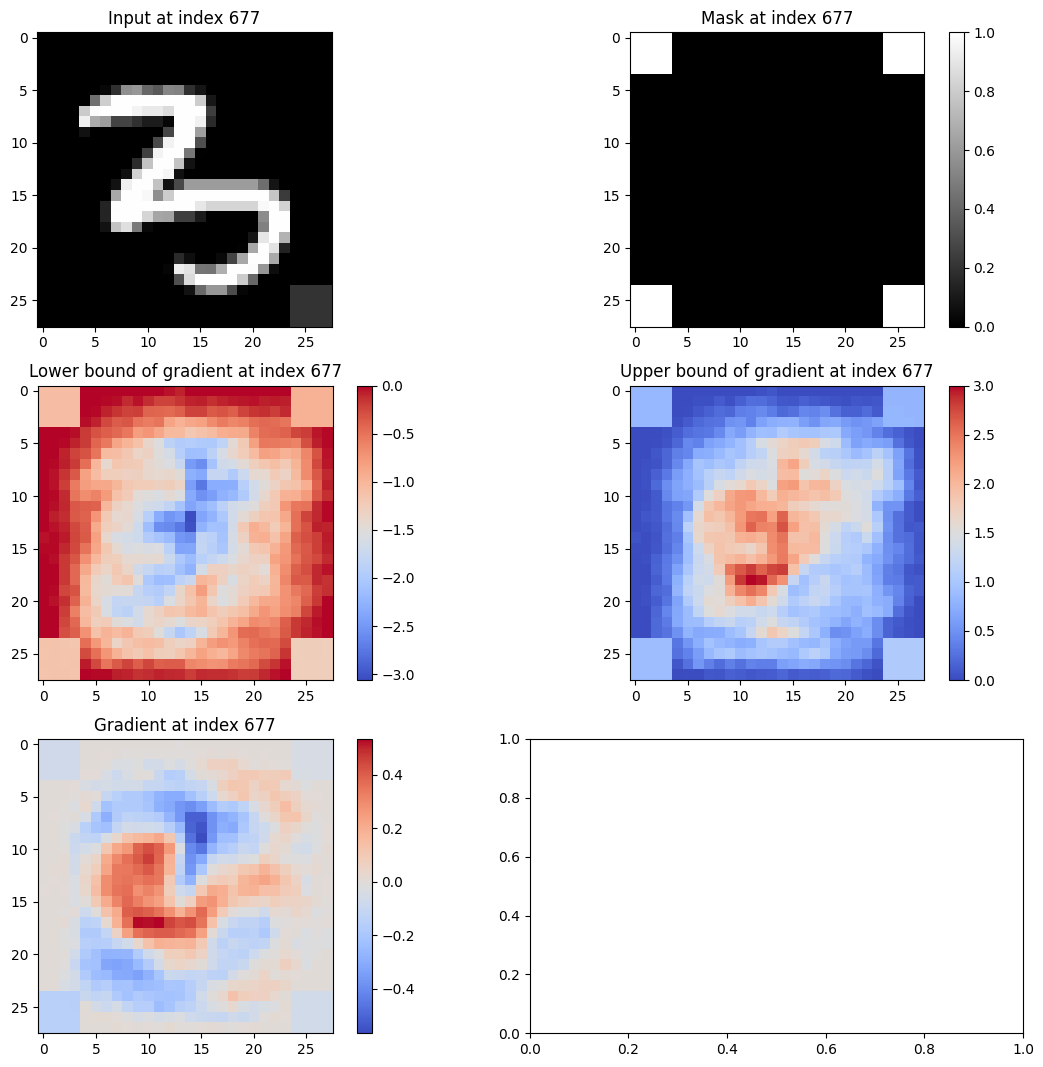

In [97]:
mlx_method = "ibp_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    test_with_masks_batch = next(iter(dl_masks_test))
    test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    if i == restarts - 1:
        visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)

## PGD Training 

In [91]:
def train_model_with_pgd_reg(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k):
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
	# pre-train the model
	progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
	for epoch in progress_bar:
		for i, (x, u, m) in enumerate(dl_masks_train):
			# Forward pass
			u, x, m = u.to(device), x.to(device).flatten(start_dim=1), m.to(device).flatten(start_dim=1)

			# For std, we will waste some time doing the bounds, but at least it is consistent across methods
			inp_grad_reg = input_gradient_pgd_regularizer(
                x, u, model, m, torch.nn.CrossEntropyLoss(), epsilon, num_iterations=10, regularizer_type=mlx_method, device=device
			)
			if mlx_method == "std":
				u = torch.nn.functional.one_hot(u, num_classes=10).squeeze().float()
				assert inp_grad_reg == 0
			output = model(x)
			std_loss = criterion(output, u)
			loss = std_loss + k * inp_grad_reg
			# Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			if i % 100 == 0:
				progress_bar.set_postfix({"std loss": std_loss.item(), "input grad loss": k * inp_grad_reg})

========== Training model with method pgd_ex restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:12<00:00,  1.26s/it, std loss=1.48, input grad loss=tensor(0.0288, device='cuda:1', grad_fn=<MulBackward0>)]


--- Pre-trained model accuracy ---
Nominal = 0.8
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0.72


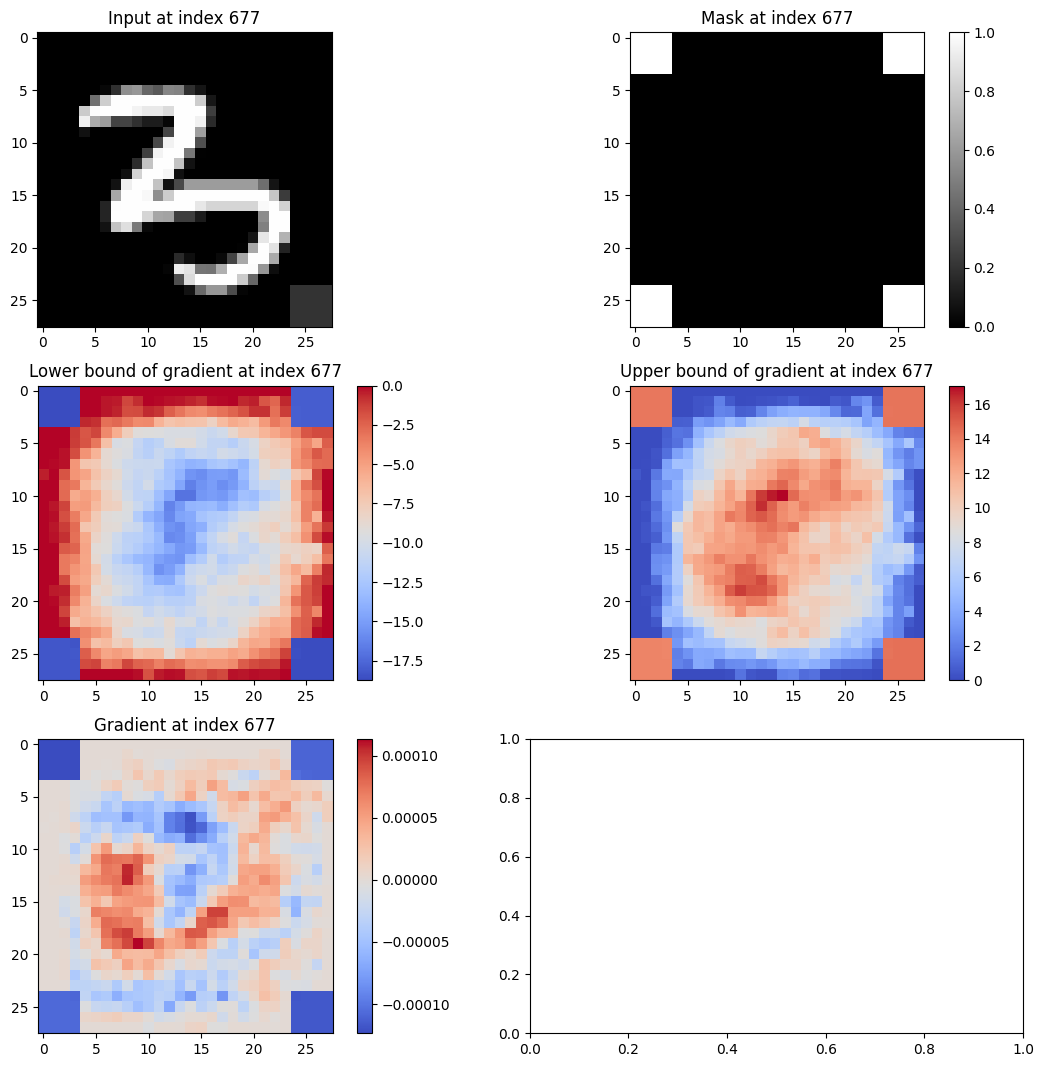

In [95]:
mlx_method = "pgd_ex"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FCNAugmented(*ARCH).to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with_pgd_reg(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, 0.2)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    test_with_masks_batch = next(iter(dl_masks_test))
    test_idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
    if i == restarts - 1:
        visualize_gradient(curr_model, *test_with_masks_batch, epsilon, test_idx_to_visualize)